In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_n_multiscale import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

In [79]:
# k_B = 1.380649e-23  # Boltzmann constant [J/K]
# hbar=  6.62607015e-34 # Planck [J/s]
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
π = np.pi
# [AU]
rs  = 3
T   = 10*eV 
Zstar=3#

β   = 1/T
m_e = 1


Λe  = np.sqrt(  β*2*π /m_e )
Λe_star  = np.sqrt(  β*2*π /m_e )/rs
print("Λee = {0:.3f}".format(Λe_star))
Γee = β/rs 
Γei = -Zstar*β/rs 
Γii = Zstar**2*β/rs 
print(Γee, Γei, Γii)

Λee = 1.378
0.9069998621360211 -2.720999586408064 8.16299875922419


Plug into get potentials

In [80]:
from scipy.special import erfc

# Build Components for QSP's

def βv_Deutsch(Γ, r):
    return Γ/r*  np.exp(-2*π*r/Λe_star)

# Kelbg looks really weird??
def βv_Kelbg(Γ,r):
#     return Γ/r*(  np.exp(-2*π*r**2/Λe_star**2)- np.sqrt(2)*π*r/Λe_star *erf(np.sqrt(2*π)*r/Λe_star))
#     return Γ/r*( 1 - np.exp(-2*π*r**2/Λe_star**2)+ np.sqrt(2)*π*r/Λe_star *(1-erf(np.sqrt(2*π)*r/Λe_star)))
    return Γ/r*( 1 - np.exp(-2*π*r**2/Λe_star**2)+ np.sqrt(2)*π*r/Λe_star*erfc(np.sqrt(2*π)*r/Λe_star))

def βv_Pauli(r):
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))


######### Build Actual QSP's

def βvee(r):
    return βv_Kelbg(Γee,r) + βv_Pauli(r)

def βvei(r):
    return βv_Kelbg(Γei,r)

def βvei_atomic(r):
    r_c = 3/5 #3/5 r_s in linear n_b(r) model
    return np.heaviside(r - r_c,0.5) * βvei(r)

def βvii(r):
    return Γii/r 


First, we initialize the hnc

In [68]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])


# Gamma = np.array(  [[50,  10],
#                     [10,  10]])

names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-6,
                 kappa_multiscale=5, rho = rho, num_iterations=int(1e4), 
                 R_max=10, N_bins=1000, names=names, dst_type=3)



In [81]:
βu_r_matrix = np.array([[βvii(hnc2.r_array), βvei(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)

In [82]:
from pandas import read_csv

r_ie, gie = np.array(read_csv("~/plasma/MM_HNC/gie.out", delim_whitespace=True)).T
r_ee, gee = np.array(read_csv("~/plasma/MM_HNC/gee.out", delim_whitespace=True)).T
r_ii, gii = np.array(read_csv("~/plasma/MM_HNC/gii.out", delim_whitespace=True)).T

data_to_compare = [gie,gee,gii]
data_to_compare = ["~/plasma/MM_HNC/gie.out","~/plasma/MM_HNC/gee.out","~/plasma/MM_HNC/gii.out"]
data_names=['MM ie', "MM ee", 'MM ii' ]

0: Err in c_r: 6.030
1: Err in c_r: 5.971
2: Err in c_r: 12.871
3: Err in c_r: 1392.083
4: Err in c_r: 1496.931
5: Err in c_r: 13072.058
6: Err in c_r: 17937.818
7: Err in c_r: 19592.474
8: Err in c_r: 28189.916
9: Err in c_r: 14854.373
10: Err in c_r: 7241.524
11: Err in c_r: 12168.035
12: Err in c_r: 89785.488
13: Err in c_r: 13804.297
14: Err in c_r: 12661.875
15: Err in c_r: 15927.969
16: Err in c_r: 16127.087
17: Err in c_r: 12195.473
18: Err in c_r: 14297.413
19: Err in c_r: 12436.720
20: Err in c_r: 14628.410
21: Err in c_r: 13074.001
22: Err in c_r: 10622.438
23: Err in c_r: 16068.260
24: Err in c_r: 13760.871
25: Err in c_r: 14636.648
26: Err in c_r: 13734.473
27: Err in c_r: 16274.445
28: Err in c_r: 17546.154
29: Err in c_r: 15781.781
30: Err in c_r: 15225.440
31: Err in c_r: 219065.428
32: Err in c_r: 15952.058
33: Err in c_r: 15557.988
34: Err in c_r: 92051.730
35: Err in c_r: 15893.864
36: Err in c_r: 16011.442
37: Err in c_r: 14934.129
38: Err in c_r: 16315.640
39: Err i

/home/zach/plasma/hnc/hnc_n_multiscale.py:286: RuntimeWarning: overflow encountered in exp
  self.h_r_matrix = -1 + np.exp(self.γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


42: Err in c_r: 16351.979
43: Err in c_r: 15877.496
44: Err in c_r: 15726.091
45: Err in c_r: 15680.433
46: Err in c_r: 15826.672
47: Err in c_r: 15980.189
48: Err in c_r: 15790.514
49: Err in c_r: 13703.639
50: Err in c_r: 16176.553
51: Err in c_r: 16213.939
52: Err in c_r: 15387.758
53: Err in c_r: 16063.658
54: Err in c_r: 15657.991
55: Err in c_r: 15663.390
56: Err in c_r: 16027.585
57: Err in c_r: 15220.615
58: Err in c_r: 16754.385
59: Err in c_r: 16057.838
60: Err in c_r: 15705.896
61: Err in c_r: 15442.844
62: Err in c_r: 18996.746
63: Err in c_r: 16172.249
64: Err in c_r: 15849.079
65: Err in c_r: 16126.989
66: Err in c_r: 16217.499
67: Err in c_r: 15911.376
68: Err in c_r: 17424.385
69: Err in c_r: 12818.652
70: Err in c_r: 16112.262
71: Err in c_r: 16099.451
72: Err in c_r: 16097.668
73: Err in c_r: 16072.686
74: Err in c_r: 16063.979
75: Err in c_r: 16043.091
76: Err in c_r: 15899.433
77: Err in c_r: 16217.493
78: Err in c_r: 15252.939
79: Err in c_r: 16128.906
80: Err in c

368: Err in c_r: 16380.770
369: Err in c_r: 16378.349
370: Err in c_r: 16375.629
371: Err in c_r: 16378.660
372: Err in c_r: 16378.731
373: Err in c_r: 16377.616
374: Err in c_r: 16368.915
375: Err in c_r: 16365.649
376: Err in c_r: 16380.889
377: Err in c_r: 16374.347
378: Err in c_r: 16376.611
379: Err in c_r: 16376.495
380: Err in c_r: 16376.331
381: Err in c_r: 16373.051
382: Err in c_r: 16369.310
383: Err in c_r: 16371.672
384: Err in c_r: 16372.191
385: Err in c_r: 16366.040
386: Err in c_r: 16366.331
387: Err in c_r: 16376.170
388: Err in c_r: 16370.137
389: Err in c_r: 16373.581
390: Err in c_r: 16366.599
391: Err in c_r: 16371.262
392: Err in c_r: 16369.848
393: Err in c_r: 16366.919
394: Err in c_r: 16370.755
395: Err in c_r: 16369.464
396: Err in c_r: 16347.946
397: Err in c_r: 16352.067
398: Err in c_r: 16356.364
399: Err in c_r: 16367.165
400: Err in c_r: 16361.007
401: Err in c_r: 16361.233
402: Err in c_r: 16359.914
403: Err in c_r: 16345.190
404: Err in c_r: 16360.202
4

689: Err in c_r: 16364.930
690: Err in c_r: 16362.159
691: Err in c_r: 16361.764
692: Err in c_r: 16364.995
693: Err in c_r: 16363.380
694: Err in c_r: 16353.483
695: Err in c_r: 16381.874
696: Err in c_r: 16371.136
697: Err in c_r: 16370.528
698: Err in c_r: 16369.799
699: Err in c_r: 16369.735
700: Err in c_r: 16369.252
701: Err in c_r: 16369.152
702: Err in c_r: 16369.157
703: Err in c_r: 16369.155
704: Err in c_r: 16368.683
705: Err in c_r: 16368.557
706: Err in c_r: 16365.567
707: Err in c_r: 16369.657
708: Err in c_r: 16369.486
709: Err in c_r: 16369.215
710: Err in c_r: 16369.124
711: Err in c_r: 16368.912
712: Err in c_r: 16366.993
713: Err in c_r: 16368.847
714: Err in c_r: 16368.544
715: Err in c_r: 16367.611
716: Err in c_r: 16368.141
717: Err in c_r: 16368.547
718: Err in c_r: 16368.303
719: Err in c_r: 16367.070
720: Err in c_r: 16367.777
721: Err in c_r: 16367.167
722: Err in c_r: 16368.163
723: Err in c_r: 16368.052
724: Err in c_r: 16367.344
725: Err in c_r: 16367.647
7

1014: Err in c_r: 16351.668
1015: Err in c_r: 16355.466
1016: Err in c_r: 16356.150
1017: Err in c_r: 16355.950
1018: Err in c_r: 16344.250
1019: Err in c_r: 16356.057
1020: Err in c_r: 16357.917
1021: Err in c_r: 16355.193
1022: Err in c_r: 16355.726
1023: Err in c_r: 16355.571
1024: Err in c_r: 16355.964
1025: Err in c_r: 16355.501
1026: Err in c_r: 16355.503
1027: Err in c_r: 16354.619
1028: Err in c_r: 16352.229
1029: Err in c_r: 16356.554
1030: Err in c_r: 16354.870
1031: Err in c_r: 16356.472
1032: Err in c_r: 16356.750
1033: Err in c_r: 16352.674
1034: Err in c_r: 16354.816
1035: Err in c_r: 16357.654
1036: Err in c_r: 16355.965
1037: Err in c_r: 16351.658
1038: Err in c_r: 16352.623
1039: Err in c_r: 16355.102
1040: Err in c_r: 16355.377
1041: Err in c_r: 16354.772
1042: Err in c_r: 16347.054
1043: Err in c_r: 16356.429
1044: Err in c_r: 16356.486
1045: Err in c_r: 16355.225
1046: Err in c_r: 16354.027
1047: Err in c_r: 16353.617
1048: Err in c_r: 16355.609
1049: Err in c_r: 16

1341: Err in c_r: 16348.581
1342: Err in c_r: 16343.765
1343: Err in c_r: 16354.865
1344: Err in c_r: 16353.798
1345: Err in c_r: 16349.092
1346: Err in c_r: 16351.177
1347: Err in c_r: 16351.926
1348: Err in c_r: 16349.526
1349: Err in c_r: 16348.989
1350: Err in c_r: 16352.026
1351: Err in c_r: 16352.115
1352: Err in c_r: 16350.170
1353: Err in c_r: 16346.769
1354: Err in c_r: 16353.886
1355: Err in c_r: 16353.318
1356: Err in c_r: 16351.027
1357: Err in c_r: 16348.448
1358: Err in c_r: 16353.322
1359: Err in c_r: 16349.328
1360: Err in c_r: 16351.453
1361: Err in c_r: 16351.451
1362: Err in c_r: 16348.105
1363: Err in c_r: 16350.280
1364: Err in c_r: 16351.184
1365: Err in c_r: 16352.048
1366: Err in c_r: 16352.462
1367: Err in c_r: 16347.713
1368: Err in c_r: 16350.752
1369: Err in c_r: 16352.796
1370: Err in c_r: 16349.297
1371: Err in c_r: 16341.711
1372: Err in c_r: 16352.861
1373: Err in c_r: 16352.233
1374: Err in c_r: 16347.218
1375: Err in c_r: 16350.037
1376: Err in c_r: 16

1666: Err in c_r: 16355.763
1667: Err in c_r: 16355.763
1668: Err in c_r: 16355.752
1669: Err in c_r: 16355.747
1670: Err in c_r: 16355.740
1671: Err in c_r: 16355.736
1672: Err in c_r: 16355.729
1673: Err in c_r: 16355.727
1674: Err in c_r: 16355.720
1675: Err in c_r: 16355.714
1676: Err in c_r: 16355.708
1677: Err in c_r: 16355.697
1678: Err in c_r: 16355.691
1679: Err in c_r: 16355.682
1680: Err in c_r: 16355.678
1681: Err in c_r: 16355.656
1682: Err in c_r: 16355.662
1683: Err in c_r: 16355.630
1684: Err in c_r: 16355.528
1685: Err in c_r: 16354.859
1686: Err in c_r: 16355.641
1687: Err in c_r: 16355.637
1688: Err in c_r: 16355.635
1689: Err in c_r: 16355.629
1690: Err in c_r: 16355.619
1691: Err in c_r: 16355.615
1692: Err in c_r: 16355.609
1693: Err in c_r: 16355.605
1694: Err in c_r: 16355.601
1695: Err in c_r: 16355.589
1696: Err in c_r: 16355.587
1697: Err in c_r: 16355.567
1698: Err in c_r: 16355.573
1699: Err in c_r: 16355.570
1700: Err in c_r: 16355.566
1701: Err in c_r: 16

1989: Err in c_r: 16354.172
1990: Err in c_r: 16354.163
1991: Err in c_r: 16354.159
1992: Err in c_r: 16354.152
1993: Err in c_r: 16354.144
1994: Err in c_r: 16354.138
1995: Err in c_r: 16354.132
1996: Err in c_r: 16354.126
1997: Err in c_r: 16354.119
1998: Err in c_r: 16354.116
1999: Err in c_r: 16354.108
2000: Err in c_r: 16354.105
2001: Err in c_r: 16354.099
2002: Err in c_r: 16354.094
2003: Err in c_r: 16354.088
2004: Err in c_r: 16354.085
2005: Err in c_r: 16354.079
2006: Err in c_r: 16354.074
2007: Err in c_r: 16354.069
2008: Err in c_r: 16354.063
2009: Err in c_r: 16354.060
2010: Err in c_r: 16354.056
2011: Err in c_r: 16354.050
2012: Err in c_r: 16354.045
2013: Err in c_r: 16354.041
2014: Err in c_r: 16354.037
2015: Err in c_r: 16354.034
2016: Err in c_r: 16354.027
2017: Err in c_r: 16354.023
2018: Err in c_r: 16354.020
2019: Err in c_r: 16354.014
2020: Err in c_r: 16354.010
2021: Err in c_r: 16354.007
2022: Err in c_r: 16354.001
2023: Err in c_r: 16353.996
2024: Err in c_r: 16

2315: Err in c_r: 16352.917
2316: Err in c_r: 16352.914
2317: Err in c_r: 16352.912
2318: Err in c_r: 16352.908
2319: Err in c_r: 16352.905
2320: Err in c_r: 16352.901
2321: Err in c_r: 16352.899
2322: Err in c_r: 16352.896
2323: Err in c_r: 16352.891
2324: Err in c_r: 16352.887
2325: Err in c_r: 16352.886
2326: Err in c_r: 16352.880
2327: Err in c_r: 16352.876
2328: Err in c_r: 16352.873
2329: Err in c_r: 16352.869
2330: Err in c_r: 16352.867
2331: Err in c_r: 16352.863
2332: Err in c_r: 16352.858
2333: Err in c_r: 16352.857
2334: Err in c_r: 16352.853
2335: Err in c_r: 16352.849
2336: Err in c_r: 16352.844
2337: Err in c_r: 16352.841
2338: Err in c_r: 16352.840
2339: Err in c_r: 16352.834
2340: Err in c_r: 16352.832
2341: Err in c_r: 16352.827
2342: Err in c_r: 16352.821
2343: Err in c_r: 16352.818
2344: Err in c_r: 16352.816
2345: Err in c_r: 16352.811
2346: Err in c_r: 16352.809
2347: Err in c_r: 16352.804
2348: Err in c_r: 16352.798
2349: Err in c_r: 16352.797
2350: Err in c_r: 16

2640: Err in c_r: 16352.069
2641: Err in c_r: 16352.067
2642: Err in c_r: 16352.064
2643: Err in c_r: 16352.061
2644: Err in c_r: 16352.061
2645: Err in c_r: 16352.057
2646: Err in c_r: 16352.056
2647: Err in c_r: 16352.051
2648: Err in c_r: 16352.051
2649: Err in c_r: 16352.046
2650: Err in c_r: 16352.046
2651: Err in c_r: 16352.042
2652: Err in c_r: 16352.039
2653: Err in c_r: 16352.040
2654: Err in c_r: 16352.035
2655: Err in c_r: 16352.033
2656: Err in c_r: 16352.028
2657: Err in c_r: 16352.028
2658: Err in c_r: 16352.027
2659: Err in c_r: 16352.022
2660: Err in c_r: 16352.022
2661: Err in c_r: 16352.018
2662: Err in c_r: 16352.017
2663: Err in c_r: 16352.013
2664: Err in c_r: 16352.009
2665: Err in c_r: 16352.007
2666: Err in c_r: 16352.006
2667: Err in c_r: 16352.004
2668: Err in c_r: 16352.000
2669: Err in c_r: 16351.998
2670: Err in c_r: 16351.997
2671: Err in c_r: 16351.991
2672: Err in c_r: 16351.991
2673: Err in c_r: 16351.989
2674: Err in c_r: 16351.986
2675: Err in c_r: 16

2963: Err in c_r: 16351.257
2964: Err in c_r: 16351.247
2965: Err in c_r: 16351.243
2966: Err in c_r: 16351.230
2967: Err in c_r: 16351.272
2968: Err in c_r: 16351.191
2969: Err in c_r: 16351.213
2970: Err in c_r: 16351.198
2971: Err in c_r: 16350.299
2972: Err in c_r: 16351.202
2973: Err in c_r: 16351.191
2974: Err in c_r: 16351.162
2975: Err in c_r: 16351.150
2976: Err in c_r: 16351.144
2977: Err in c_r: 16351.136
2978: Err in c_r: 16351.112
2979: Err in c_r: 16351.093
2980: Err in c_r: 16351.080
2981: Err in c_r: 16351.062
2982: Err in c_r: 16351.039
2983: Err in c_r: 16351.000
2984: Err in c_r: 16350.960
2985: Err in c_r: 16350.917
2986: Err in c_r: 16350.848
2987: Err in c_r: 16350.771
2988: Err in c_r: 16350.695
2989: Err in c_r: 16350.578
2990: Err in c_r: 16350.409
2991: Err in c_r: 16350.230
2992: Err in c_r: 16349.876
2993: Err in c_r: 16349.010
2994: Err in c_r: 16347.646
2995: Err in c_r: 16312.746
2996: Err in c_r: 16351.608
2997: Err in c_r: 16351.578
2998: Err in c_r: 16

3289: Err in c_r: 16350.884
3290: Err in c_r: 16350.882
3291: Err in c_r: 16350.880
3292: Err in c_r: 16350.876
3293: Err in c_r: 16350.874
3294: Err in c_r: 16350.869
3295: Err in c_r: 16350.862
3296: Err in c_r: 16350.863
3297: Err in c_r: 16350.861
3298: Err in c_r: 16350.864
3299: Err in c_r: 16350.861
3300: Err in c_r: 16350.858
3301: Err in c_r: 16350.856
3302: Err in c_r: 16350.853
3303: Err in c_r: 16350.852
3304: Err in c_r: 16350.850
3305: Err in c_r: 16350.849
3306: Err in c_r: 16350.846
3307: Err in c_r: 16350.845
3308: Err in c_r: 16350.845
3309: Err in c_r: 16350.842
3310: Err in c_r: 16350.841
3311: Err in c_r: 16350.837
3312: Err in c_r: 16350.836
3313: Err in c_r: 16350.833
3314: Err in c_r: 16350.832
3315: Err in c_r: 16350.821
3316: Err in c_r: 16350.813
3317: Err in c_r: 16350.817
3318: Err in c_r: 16350.817
3319: Err in c_r: 16350.817
3320: Err in c_r: 16350.817
3321: Err in c_r: 16350.816
3322: Err in c_r: 16350.815
3323: Err in c_r: 16350.811
3324: Err in c_r: 16

3617: Err in c_r: 16350.385
3618: Err in c_r: 16350.385
3619: Err in c_r: 16350.382
3620: Err in c_r: 16350.381
3621: Err in c_r: 16350.380
3622: Err in c_r: 16350.374
3623: Err in c_r: 16350.374
3624: Err in c_r: 16350.376
3625: Err in c_r: 16350.374
3626: Err in c_r: 16350.369
3627: Err in c_r: 16350.370
3628: Err in c_r: 16350.371
3629: Err in c_r: 16350.368
3630: Err in c_r: 16350.357
3631: Err in c_r: 16350.355
3632: Err in c_r: 16350.355
3633: Err in c_r: 16350.350
3634: Err in c_r: 16350.356
3635: Err in c_r: 16350.343
3636: Err in c_r: 16350.351
3637: Err in c_r: 16350.348
3638: Err in c_r: 16350.343
3639: Err in c_r: 16350.340
3640: Err in c_r: 16350.337
3641: Err in c_r: 16350.334
3642: Err in c_r: 16350.332
3643: Err in c_r: 16350.330
3644: Err in c_r: 16350.328
3645: Err in c_r: 16350.320
3646: Err in c_r: 16350.319
3647: Err in c_r: 16350.312
3648: Err in c_r: 16350.294
3649: Err in c_r: 16350.272
3650: Err in c_r: 16350.262
3651: Err in c_r: 16350.215
3652: Err in c_r: 16

3946: Err in c_r: 16350.020
3947: Err in c_r: 16350.024
3948: Err in c_r: 16350.020
3949: Err in c_r: 16350.017
3950: Err in c_r: 16350.014
3951: Err in c_r: 16350.015
3952: Err in c_r: 16350.012
3953: Err in c_r: 16350.010
3954: Err in c_r: 16350.008
3955: Err in c_r: 16350.006
3956: Err in c_r: 16350.004
3957: Err in c_r: 16350.005
3958: Err in c_r: 16350.003
3959: Err in c_r: 16350.001
3960: Err in c_r: 16350.003
3961: Err in c_r: 16350.004
3962: Err in c_r: 16350.000
3963: Err in c_r: 16349.997
3964: Err in c_r: 16349.999
3965: Err in c_r: 16349.994
3966: Err in c_r: 16349.998
3967: Err in c_r: 16349.995
3968: Err in c_r: 16349.991
3969: Err in c_r: 16349.990
3970: Err in c_r: 16349.991
3971: Err in c_r: 16349.990
3972: Err in c_r: 16349.988
3973: Err in c_r: 16349.987
3974: Err in c_r: 16349.986
3975: Err in c_r: 16349.985
3976: Err in c_r: 16349.984
3977: Err in c_r: 16349.983
3978: Err in c_r: 16349.982
3979: Err in c_r: 16349.983
3980: Err in c_r: 16349.978
3981: Err in c_r: 16

4271: Err in c_r: 16349.695
4272: Err in c_r: 16349.696
4273: Err in c_r: 16349.694
4274: Err in c_r: 16349.695
4275: Err in c_r: 16349.692
4276: Err in c_r: 16349.693
4277: Err in c_r: 16349.688
4278: Err in c_r: 16349.689
4279: Err in c_r: 16349.689
4280: Err in c_r: 16349.688
4281: Err in c_r: 16349.686
4282: Err in c_r: 16349.686
4283: Err in c_r: 16349.686
4284: Err in c_r: 16349.683
4285: Err in c_r: 16349.685
4286: Err in c_r: 16349.683
4287: Err in c_r: 16349.679
4288: Err in c_r: 16349.680
4289: Err in c_r: 16349.679
4290: Err in c_r: 16349.677
4291: Err in c_r: 16349.678
4292: Err in c_r: 16349.676
4293: Err in c_r: 16349.674
4294: Err in c_r: 16349.676
4295: Err in c_r: 16349.673
4296: Err in c_r: 16349.673
4297: Err in c_r: 16349.671
4298: Err in c_r: 16349.671
4299: Err in c_r: 16349.669
4300: Err in c_r: 16349.671
4301: Err in c_r: 16349.668
4302: Err in c_r: 16349.666
4303: Err in c_r: 16349.666
4304: Err in c_r: 16349.665
4305: Err in c_r: 16349.663
4306: Err in c_r: 16

4593: Err in c_r: 16349.420
4594: Err in c_r: 16349.419
4595: Err in c_r: 16349.419
4596: Err in c_r: 16349.418
4597: Err in c_r: 16349.418
4598: Err in c_r: 16349.417
4599: Err in c_r: 16349.415
4600: Err in c_r: 16349.416
4601: Err in c_r: 16349.413
4602: Err in c_r: 16349.410
4603: Err in c_r: 16349.413
4604: Err in c_r: 16349.410
4605: Err in c_r: 16349.409
4606: Err in c_r: 16349.411
4607: Err in c_r: 16349.408
4608: Err in c_r: 16349.410
4609: Err in c_r: 16349.407
4610: Err in c_r: 16349.406
4611: Err in c_r: 16349.405
4612: Err in c_r: 16349.407
4613: Err in c_r: 16349.404
4614: Err in c_r: 16349.404
4615: Err in c_r: 16349.403
4616: Err in c_r: 16349.403
4617: Err in c_r: 16349.400
4618: Err in c_r: 16349.401
4619: Err in c_r: 16349.399
4620: Err in c_r: 16349.399
4621: Err in c_r: 16349.399
4622: Err in c_r: 16349.398
4623: Err in c_r: 16349.396
4624: Err in c_r: 16349.396
4625: Err in c_r: 16349.396
4626: Err in c_r: 16349.395
4627: Err in c_r: 16349.393
4628: Err in c_r: 16

4919: Err in c_r: 16349.180
4920: Err in c_r: 16349.180
4921: Err in c_r: 16349.179
4922: Err in c_r: 16349.177
4923: Err in c_r: 16349.178
4924: Err in c_r: 16349.176
4925: Err in c_r: 16349.177
4926: Err in c_r: 16349.174
4927: Err in c_r: 16349.174
4928: Err in c_r: 16349.174
4929: Err in c_r: 16349.171
4930: Err in c_r: 16349.172
4931: Err in c_r: 16349.172
4932: Err in c_r: 16349.169
4933: Err in c_r: 16349.171
4934: Err in c_r: 16349.169
4935: Err in c_r: 16349.170
4936: Err in c_r: 16349.170
4937: Err in c_r: 16349.167
4938: Err in c_r: 16349.166
4939: Err in c_r: 16349.167
4940: Err in c_r: 16349.164
4941: Err in c_r: 16349.166
4942: Err in c_r: 16349.164
4943: Err in c_r: 16349.162
4944: Err in c_r: 16349.163
4945: Err in c_r: 16349.161
4946: Err in c_r: 16349.162
4947: Err in c_r: 16349.160
4948: Err in c_r: 16349.162
4949: Err in c_r: 16349.157
4950: Err in c_r: 16349.159
4951: Err in c_r: 16349.158
4952: Err in c_r: 16349.156
4953: Err in c_r: 16349.156
4954: Err in c_r: 16

5233: Err in c_r: 16348.977
5234: Err in c_r: 16348.977
5235: Err in c_r: 16348.975
5236: Err in c_r: 16348.976
5237: Err in c_r: 16348.974
5238: Err in c_r: 16348.974
5239: Err in c_r: 16348.972
5240: Err in c_r: 16348.971
5241: Err in c_r: 16348.971
5242: Err in c_r: 16348.971
5243: Err in c_r: 16348.971
5244: Err in c_r: 16348.970
5245: Err in c_r: 16348.969
5246: Err in c_r: 16348.968
5247: Err in c_r: 16348.966
5248: Err in c_r: 16348.967
5249: Err in c_r: 16348.968
5250: Err in c_r: 16348.966
5251: Err in c_r: 16348.965
5252: Err in c_r: 16348.963
5253: Err in c_r: 16348.964
5254: Err in c_r: 16348.964
5255: Err in c_r: 16348.963
5256: Err in c_r: 16348.962
5257: Err in c_r: 16348.961
5258: Err in c_r: 16348.961
5259: Err in c_r: 16348.960
5260: Err in c_r: 16348.963
5261: Err in c_r: 16348.957
5262: Err in c_r: 16348.959
5263: Err in c_r: 16348.958
5264: Err in c_r: 16348.955
5265: Err in c_r: 16348.957
5266: Err in c_r: 16348.958
5267: Err in c_r: 16348.954
5268: Err in c_r: 16

5552: Err in c_r: 16348.787
5553: Err in c_r: 16348.785
5554: Err in c_r: 16348.787
5555: Err in c_r: 16348.784
5556: Err in c_r: 16348.785
5557: Err in c_r: 16348.786
5558: Err in c_r: 16348.785
5559: Err in c_r: 16348.783
5560: Err in c_r: 16348.784
5561: Err in c_r: 16348.782
5562: Err in c_r: 16348.780
5563: Err in c_r: 16348.781
5564: Err in c_r: 16348.781
5565: Err in c_r: 16348.779
5566: Err in c_r: 16348.781
5567: Err in c_r: 16348.778
5568: Err in c_r: 16348.779
5569: Err in c_r: 16348.779
5570: Err in c_r: 16348.777
5571: Err in c_r: 16348.775
5572: Err in c_r: 16348.776
5573: Err in c_r: 16348.774
5574: Err in c_r: 16348.775
5575: Err in c_r: 16348.773
5576: Err in c_r: 16348.771
5577: Err in c_r: 16348.772
5578: Err in c_r: 16348.773
5579: Err in c_r: 16348.770
5580: Err in c_r: 16348.770
5581: Err in c_r: 16348.771
5582: Err in c_r: 16348.770
5583: Err in c_r: 16348.768
5584: Err in c_r: 16348.770
5585: Err in c_r: 16348.767
5586: Err in c_r: 16348.768
5587: Err in c_r: 16

5882: Err in c_r: 16348.653
5883: Err in c_r: 16348.649
5884: Err in c_r: 16348.651
5885: Err in c_r: 16348.650
5886: Err in c_r: 16348.649
5887: Err in c_r: 16348.648
5888: Err in c_r: 16348.646
5889: Err in c_r: 16348.645
5890: Err in c_r: 16348.648
5891: Err in c_r: 16348.645
5892: Err in c_r: 16348.645
5893: Err in c_r: 16348.646
5894: Err in c_r: 16348.643
5895: Err in c_r: 16348.643
5896: Err in c_r: 16348.644
5897: Err in c_r: 16348.642
5898: Err in c_r: 16348.642
5899: Err in c_r: 16348.640
5900: Err in c_r: 16348.639
5901: Err in c_r: 16348.639
5902: Err in c_r: 16348.642
5903: Err in c_r: 16348.637
5904: Err in c_r: 16348.639
5905: Err in c_r: 16348.638
5906: Err in c_r: 16348.637
5907: Err in c_r: 16348.636
5908: Err in c_r: 16348.637
5909: Err in c_r: 16348.636
5910: Err in c_r: 16348.634
5911: Err in c_r: 16348.635
5912: Err in c_r: 16348.631
5913: Err in c_r: 16348.632
5914: Err in c_r: 16348.635
5915: Err in c_r: 16348.632
5916: Err in c_r: 16348.631
5917: Err in c_r: 16

6205: Err in c_r: 16348.492
6206: Err in c_r: 16348.491
6207: Err in c_r: 16348.491
6208: Err in c_r: 16348.491
6209: Err in c_r: 16348.489
6210: Err in c_r: 16348.491
6211: Err in c_r: 16348.489
6212: Err in c_r: 16348.488
6213: Err in c_r: 16348.488
6214: Err in c_r: 16348.489
6215: Err in c_r: 16348.487
6216: Err in c_r: 16348.487
6217: Err in c_r: 16348.486
6218: Err in c_r: 16348.486
6219: Err in c_r: 16348.486
6220: Err in c_r: 16348.486
6221: Err in c_r: 16348.485
6222: Err in c_r: 16348.485
6223: Err in c_r: 16348.484
6224: Err in c_r: 16348.484
6225: Err in c_r: 16348.482
6226: Err in c_r: 16348.484
6227: Err in c_r: 16348.483
6228: Err in c_r: 16348.480
6229: Err in c_r: 16348.482
6230: Err in c_r: 16348.479
6231: Err in c_r: 16348.481
6232: Err in c_r: 16348.481
6233: Err in c_r: 16348.479
6234: Err in c_r: 16348.479
6235: Err in c_r: 16348.481
6236: Err in c_r: 16348.477
6237: Err in c_r: 16348.477
6238: Err in c_r: 16348.478
6239: Err in c_r: 16348.476
6240: Err in c_r: 16

6516: Err in c_r: 16348.363
6517: Err in c_r: 16348.365
6518: Err in c_r: 16348.363
6519: Err in c_r: 16348.360
6520: Err in c_r: 16348.363
6521: Err in c_r: 16348.361
6522: Err in c_r: 16348.360
6523: Err in c_r: 16348.363
6524: Err in c_r: 16348.359
6525: Err in c_r: 16348.358
6526: Err in c_r: 16348.359
6527: Err in c_r: 16348.360
6528: Err in c_r: 16348.358
6529: Err in c_r: 16348.357
6530: Err in c_r: 16348.356
6531: Err in c_r: 16348.356
6532: Err in c_r: 16348.359
6533: Err in c_r: 16348.356
6534: Err in c_r: 16348.356
6535: Err in c_r: 16348.356
6536: Err in c_r: 16348.354
6537: Err in c_r: 16348.357
6538: Err in c_r: 16348.353
6539: Err in c_r: 16348.351
6540: Err in c_r: 16348.355
6541: Err in c_r: 16348.354
6542: Err in c_r: 16348.353
6543: Err in c_r: 16348.351
6544: Err in c_r: 16348.353
6545: Err in c_r: 16348.350
6546: Err in c_r: 16348.351
6547: Err in c_r: 16348.351
6548: Err in c_r: 16348.351
6549: Err in c_r: 16348.349
6550: Err in c_r: 16348.351
6551: Err in c_r: 16

6834: Err in c_r: 16348.246
6835: Err in c_r: 16348.244
6836: Err in c_r: 16348.244
6837: Err in c_r: 16348.242
6838: Err in c_r: 16348.242
6839: Err in c_r: 16348.241
6840: Err in c_r: 16348.245
6841: Err in c_r: 16348.240
6842: Err in c_r: 16348.241
6843: Err in c_r: 16348.241
6844: Err in c_r: 16348.240
6845: Err in c_r: 16348.241
6846: Err in c_r: 16348.240
6847: Err in c_r: 16348.241
6848: Err in c_r: 16348.240
6849: Err in c_r: 16348.239
6850: Err in c_r: 16348.240
6851: Err in c_r: 16348.237
6852: Err in c_r: 16348.238
6853: Err in c_r: 16348.237
6854: Err in c_r: 16348.237
6855: Err in c_r: 16348.235
6856: Err in c_r: 16348.237
6857: Err in c_r: 16348.236
6858: Err in c_r: 16348.234
6859: Err in c_r: 16348.237
6860: Err in c_r: 16348.235
6861: Err in c_r: 16348.236
6862: Err in c_r: 16348.233
6863: Err in c_r: 16348.234
6864: Err in c_r: 16348.231
6865: Err in c_r: 16348.235
6866: Err in c_r: 16348.233
6867: Err in c_r: 16348.232
6868: Err in c_r: 16348.232
6869: Err in c_r: 16

7153: Err in c_r: 16348.138
7154: Err in c_r: 16348.135
7155: Err in c_r: 16348.134
7156: Err in c_r: 16348.136
7157: Err in c_r: 16348.134
7158: Err in c_r: 16348.134
7159: Err in c_r: 16348.134
7160: Err in c_r: 16348.133
7161: Err in c_r: 16348.133
7162: Err in c_r: 16348.135
7163: Err in c_r: 16348.131
7164: Err in c_r: 16348.131
7165: Err in c_r: 16348.134
7166: Err in c_r: 16348.130
7167: Err in c_r: 16348.134
7168: Err in c_r: 16348.129
7169: Err in c_r: 16348.131
7170: Err in c_r: 16348.128
7171: Err in c_r: 16348.133
7172: Err in c_r: 16348.128
7173: Err in c_r: 16348.129
7174: Err in c_r: 16348.129
7175: Err in c_r: 16348.127
7176: Err in c_r: 16348.128
7177: Err in c_r: 16348.129
7178: Err in c_r: 16348.129
7179: Err in c_r: 16348.127
7180: Err in c_r: 16348.127
7181: Err in c_r: 16348.127
7182: Err in c_r: 16348.128
7183: Err in c_r: 16348.124
7184: Err in c_r: 16348.124
7185: Err in c_r: 16348.125
7186: Err in c_r: 16348.127
7187: Err in c_r: 16348.127
7188: Err in c_r: 16

7480: Err in c_r: 16348.034
7481: Err in c_r: 16348.033
7482: Err in c_r: 16348.033
7483: Err in c_r: 16348.033
7484: Err in c_r: 16348.031
7485: Err in c_r: 16348.032
7486: Err in c_r: 16348.034
7487: Err in c_r: 16348.032
7488: Err in c_r: 16348.032
7489: Err in c_r: 16348.030
7490: Err in c_r: 16348.031
7491: Err in c_r: 16348.030
7492: Err in c_r: 16348.030
7493: Err in c_r: 16348.028
7494: Err in c_r: 16348.029
7495: Err in c_r: 16348.030
7496: Err in c_r: 16348.031
7497: Err in c_r: 16348.028
7498: Err in c_r: 16348.029
7499: Err in c_r: 16348.027
7500: Err in c_r: 16348.028
7501: Err in c_r: 16348.026
7502: Err in c_r: 16348.027
7503: Err in c_r: 16348.028
7504: Err in c_r: 16348.026
7505: Err in c_r: 16348.026
7506: Err in c_r: 16348.026
7507: Err in c_r: 16348.026
7508: Err in c_r: 16348.024
7509: Err in c_r: 16348.026
7510: Err in c_r: 16348.025
7511: Err in c_r: 16348.023
7512: Err in c_r: 16348.023
7513: Err in c_r: 16348.025
7514: Err in c_r: 16348.024
7515: Err in c_r: 16

7803: Err in c_r: 16347.932
7804: Err in c_r: 16347.933
7805: Err in c_r: 16347.932
7806: Err in c_r: 16347.933
7807: Err in c_r: 16347.933
7808: Err in c_r: 16347.931
7809: Err in c_r: 16347.930
7810: Err in c_r: 16347.932
7811: Err in c_r: 16347.931
7812: Err in c_r: 16347.930
7813: Err in c_r: 16347.930
7814: Err in c_r: 16347.928
7815: Err in c_r: 16347.929
7816: Err in c_r: 16347.929
7817: Err in c_r: 16347.928
7818: Err in c_r: 16347.926
7819: Err in c_r: 16347.927
7820: Err in c_r: 16347.924
7821: Err in c_r: 16347.929
7822: Err in c_r: 16347.926
7823: Err in c_r: 16347.926
7824: Err in c_r: 16347.924
7825: Err in c_r: 16347.924
7826: Err in c_r: 16347.924
7827: Err in c_r: 16347.925
7828: Err in c_r: 16347.923
7829: Err in c_r: 16347.923
7830: Err in c_r: 16347.922
7831: Err in c_r: 16347.921
7832: Err in c_r: 16347.922
7833: Err in c_r: 16347.920
7834: Err in c_r: 16347.922
7835: Err in c_r: 16347.917
7836: Err in c_r: 16347.919
7837: Err in c_r: 16347.920
7838: Err in c_r: 16

8130: Err in c_r: 16347.867
8131: Err in c_r: 16347.867
8132: Err in c_r: 16347.865
8133: Err in c_r: 16347.865
8134: Err in c_r: 16347.866
8135: Err in c_r: 16347.862
8136: Err in c_r: 16347.866
8137: Err in c_r: 16347.865
8138: Err in c_r: 16347.864
8139: Err in c_r: 16347.864
8140: Err in c_r: 16347.864
8141: Err in c_r: 16347.864
8142: Err in c_r: 16347.862
8143: Err in c_r: 16347.862
8144: Err in c_r: 16347.863
8145: Err in c_r: 16347.861
8146: Err in c_r: 16347.862
8147: Err in c_r: 16347.863
8148: Err in c_r: 16347.862
8149: Err in c_r: 16347.861
8150: Err in c_r: 16347.860
8151: Err in c_r: 16347.861
8152: Err in c_r: 16347.861
8153: Err in c_r: 16347.860
8154: Err in c_r: 16347.861
8155: Err in c_r: 16347.858
8156: Err in c_r: 16347.858
8157: Err in c_r: 16347.860
8158: Err in c_r: 16347.859
8159: Err in c_r: 16347.858
8160: Err in c_r: 16347.857
8161: Err in c_r: 16347.858
8162: Err in c_r: 16347.857
8163: Err in c_r: 16347.858
8164: Err in c_r: 16347.859
8165: Err in c_r: 16

8446: Err in c_r: 16347.787
8447: Err in c_r: 16347.787
8448: Err in c_r: 16347.790
8449: Err in c_r: 16347.785
8450: Err in c_r: 16347.785
8451: Err in c_r: 16347.786
8452: Err in c_r: 16347.787
8453: Err in c_r: 16347.784
8454: Err in c_r: 16347.785
8455: Err in c_r: 16347.785
8456: Err in c_r: 16347.786
8457: Err in c_r: 16347.785
8458: Err in c_r: 16347.784
8459: Err in c_r: 16347.783
8460: Err in c_r: 16347.784
8461: Err in c_r: 16347.785
8462: Err in c_r: 16347.783
8463: Err in c_r: 16347.783
8464: Err in c_r: 16347.785
8465: Err in c_r: 16347.783
8466: Err in c_r: 16347.782
8467: Err in c_r: 16347.782
8468: Err in c_r: 16347.780
8469: Err in c_r: 16347.781
8470: Err in c_r: 16347.782
8471: Err in c_r: 16347.782
8472: Err in c_r: 16347.783
8473: Err in c_r: 16347.779
8474: Err in c_r: 16347.781
8475: Err in c_r: 16347.779
8476: Err in c_r: 16347.783
8477: Err in c_r: 16347.782
8478: Err in c_r: 16347.779
8479: Err in c_r: 16347.779
8480: Err in c_r: 16347.777
8481: Err in c_r: 16

8768: Err in c_r: 16347.714
8769: Err in c_r: 16347.716
8770: Err in c_r: 16347.715
8771: Err in c_r: 16347.714
8772: Err in c_r: 16347.713
8773: Err in c_r: 16347.716
8774: Err in c_r: 16347.713
8775: Err in c_r: 16347.712
8776: Err in c_r: 16347.715
8777: Err in c_r: 16347.714
8778: Err in c_r: 16347.714
8779: Err in c_r: 16347.712
8780: Err in c_r: 16347.711
8781: Err in c_r: 16347.714
8782: Err in c_r: 16347.712
8783: Err in c_r: 16347.712
8784: Err in c_r: 16347.712
8785: Err in c_r: 16347.714
8786: Err in c_r: 16347.710
8787: Err in c_r: 16347.709
8788: Err in c_r: 16347.711
8789: Err in c_r: 16347.710
8790: Err in c_r: 16347.710
8791: Err in c_r: 16347.710
8792: Err in c_r: 16347.709
8793: Err in c_r: 16347.711
8794: Err in c_r: 16347.711
8795: Err in c_r: 16347.708
8796: Err in c_r: 16347.709
8797: Err in c_r: 16347.709
8798: Err in c_r: 16347.707
8799: Err in c_r: 16347.708
8800: Err in c_r: 16347.710
8801: Err in c_r: 16347.707
8802: Err in c_r: 16347.708
8803: Err in c_r: 16

9079: Err in c_r: 16347.649
9080: Err in c_r: 16347.648
9081: Err in c_r: 16347.650
9082: Err in c_r: 16347.651
9083: Err in c_r: 16347.649
9084: Err in c_r: 16347.649
9085: Err in c_r: 16347.652
9086: Err in c_r: 16347.648
9087: Err in c_r: 16347.648
9088: Err in c_r: 16347.649
9089: Err in c_r: 16347.647
9090: Err in c_r: 16347.647
9091: Err in c_r: 16347.647
9092: Err in c_r: 16347.648
9093: Err in c_r: 16347.650
9094: Err in c_r: 16347.649
9095: Err in c_r: 16347.645
9096: Err in c_r: 16347.648
9097: Err in c_r: 16347.649
9098: Err in c_r: 16347.645
9099: Err in c_r: 16347.645
9100: Err in c_r: 16347.648
9101: Err in c_r: 16347.648
9102: Err in c_r: 16347.646
9103: Err in c_r: 16347.643
9104: Err in c_r: 16347.646
9105: Err in c_r: 16347.643
9106: Err in c_r: 16347.646
9107: Err in c_r: 16347.643
9108: Err in c_r: 16347.646
9109: Err in c_r: 16347.645
9110: Err in c_r: 16347.645
9111: Err in c_r: 16347.645
9112: Err in c_r: 16347.643
9113: Err in c_r: 16347.644
9114: Err in c_r: 16

9376: Err in c_r: 16347.593
9377: Err in c_r: 16347.593
9378: Err in c_r: 16347.592
9379: Err in c_r: 16347.591
9380: Err in c_r: 16347.591
9381: Err in c_r: 16347.592
9382: Err in c_r: 16347.593
9383: Err in c_r: 16347.591
9384: Err in c_r: 16347.590
9385: Err in c_r: 16347.591
9386: Err in c_r: 16347.589
9387: Err in c_r: 16347.591
9388: Err in c_r: 16347.589
9389: Err in c_r: 16347.590
9390: Err in c_r: 16347.590
9391: Err in c_r: 16347.589
9392: Err in c_r: 16347.588
9393: Err in c_r: 16347.588
9394: Err in c_r: 16347.591
9395: Err in c_r: 16347.587
9396: Err in c_r: 16347.590
9397: Err in c_r: 16347.590
9398: Err in c_r: 16347.587
9399: Err in c_r: 16347.587
9400: Err in c_r: 16347.589
9401: Err in c_r: 16347.586
9402: Err in c_r: 16347.587
9403: Err in c_r: 16347.588
9404: Err in c_r: 16347.585
9405: Err in c_r: 16347.587
9406: Err in c_r: 16347.589
9407: Err in c_r: 16347.589
9408: Err in c_r: 16347.585
9409: Err in c_r: 16347.587
9410: Err in c_r: 16347.586
9411: Err in c_r: 16

9684: Err in c_r: 16347.535
9685: Err in c_r: 16347.537
9686: Err in c_r: 16347.536
9687: Err in c_r: 16347.536
9688: Err in c_r: 16347.536
9689: Err in c_r: 16347.537
9690: Err in c_r: 16347.534
9691: Err in c_r: 16347.535
9692: Err in c_r: 16347.534
9693: Err in c_r: 16347.533
9694: Err in c_r: 16347.536
9695: Err in c_r: 16347.536
9696: Err in c_r: 16347.536
9697: Err in c_r: 16347.534
9698: Err in c_r: 16347.533
9699: Err in c_r: 16347.533
9700: Err in c_r: 16347.535
9701: Err in c_r: 16347.533
9702: Err in c_r: 16347.534
9703: Err in c_r: 16347.532
9704: Err in c_r: 16347.531
9705: Err in c_r: 16347.532
9706: Err in c_r: 16347.536
9707: Err in c_r: 16347.532
9708: Err in c_r: 16347.531
9709: Err in c_r: 16347.534
9710: Err in c_r: 16347.529
9711: Err in c_r: 16347.529
9712: Err in c_r: 16347.533
9713: Err in c_r: 16347.532
9714: Err in c_r: 16347.530
9715: Err in c_r: 16347.533
9716: Err in c_r: 16347.531
9717: Err in c_r: 16347.530
9718: Err in c_r: 16347.530
9719: Err in c_r: 16

9993: Err in c_r: 16347.483
9994: Err in c_r: 16347.486
9995: Err in c_r: 16347.485
9996: Err in c_r: 16347.482
9997: Err in c_r: 16347.484
9998: Err in c_r: 16347.482
9999: Err in c_r: 16347.481


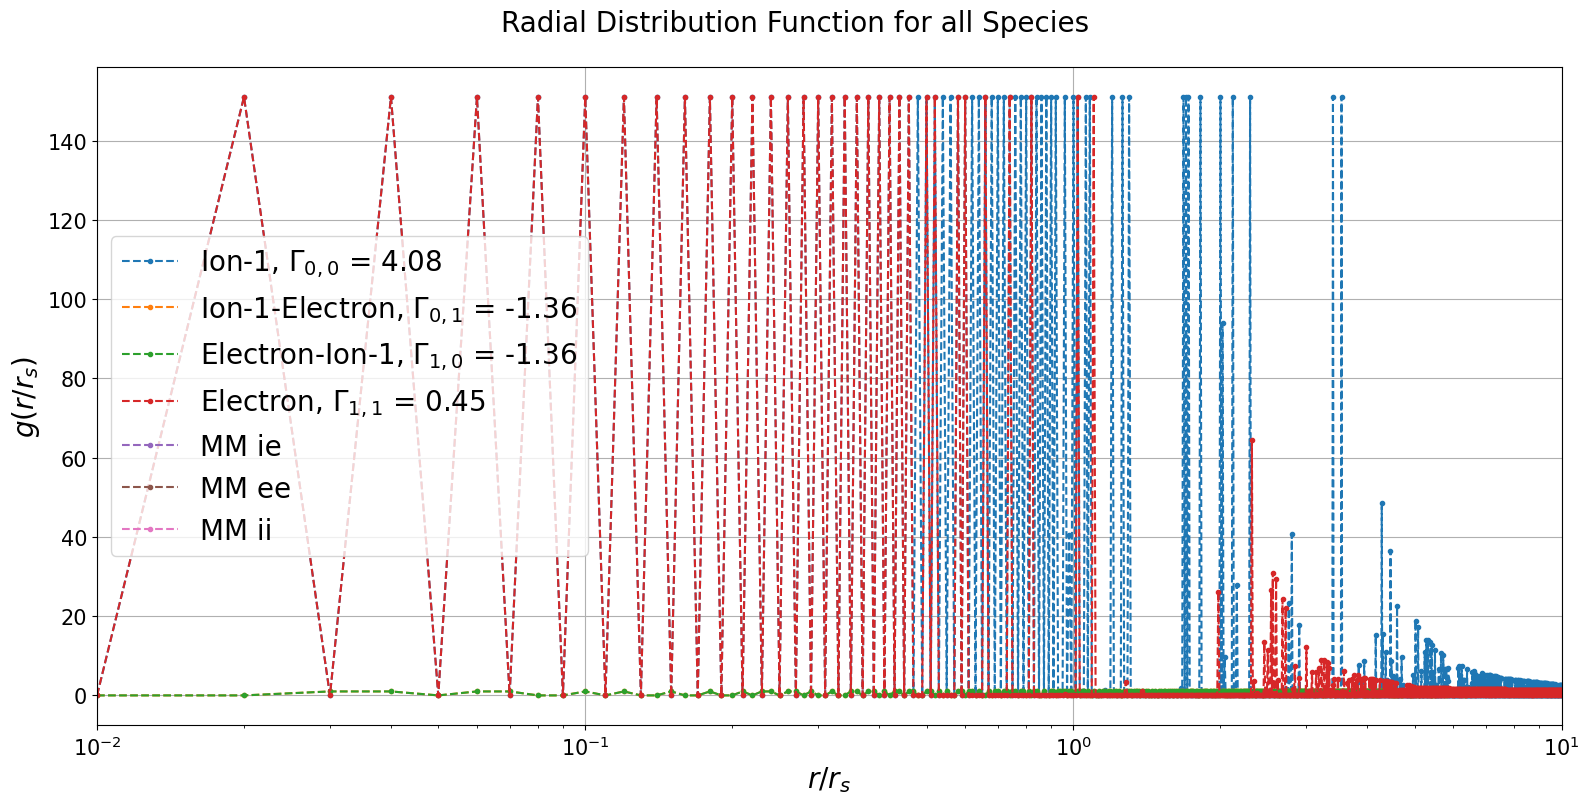

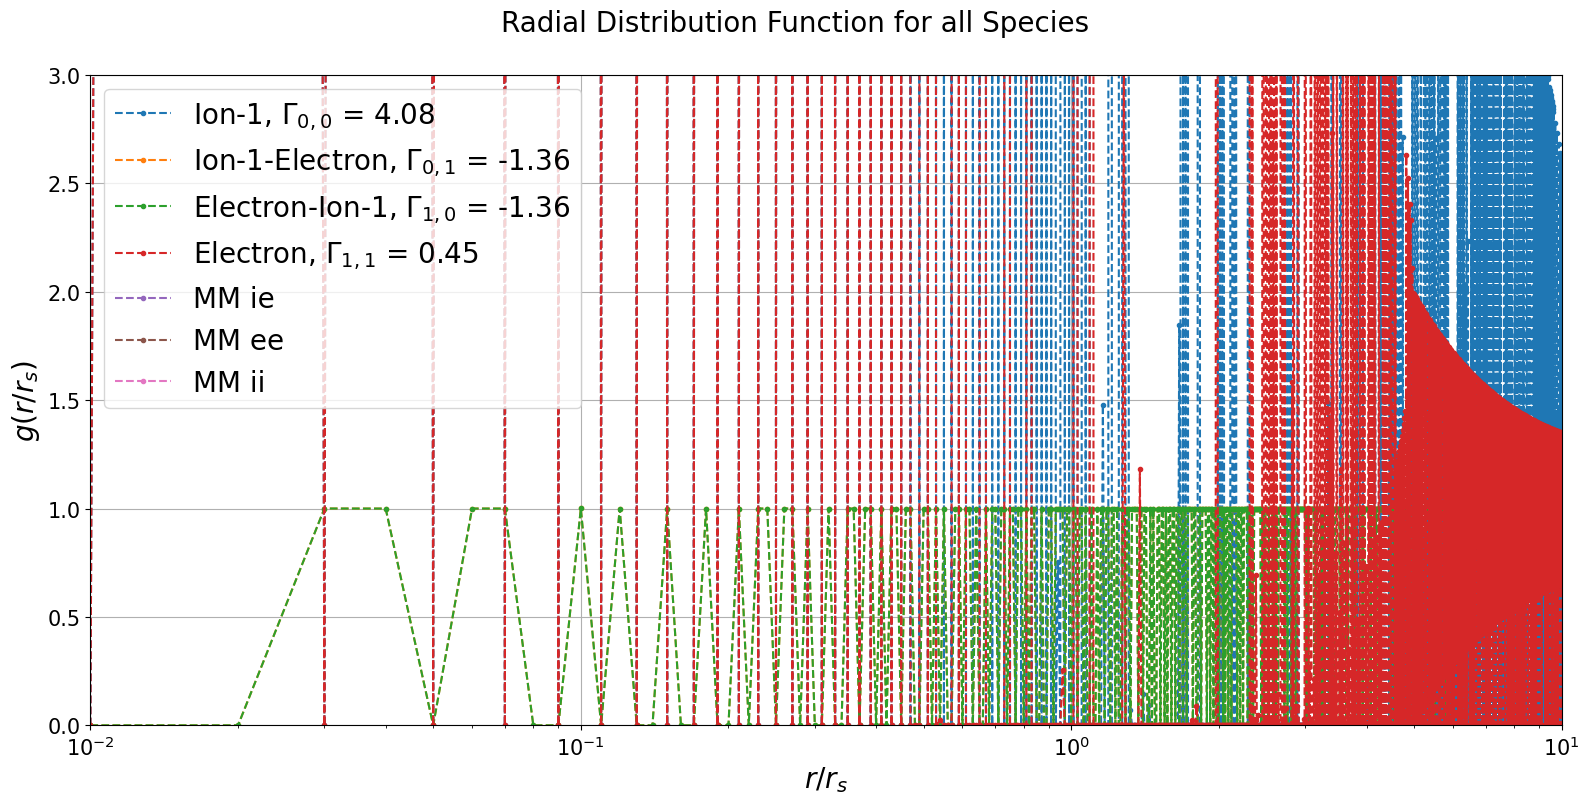

/home/zach/plasma/hnc/hnc_n_multiscale.py:385: RuntimeWarning: overflow encountered in exp
  axs[1,1].plot(self.r_array, np.exp(self.γs_r_matrix + self.βu_l_r_matrix)[species_nums] ,'--.')


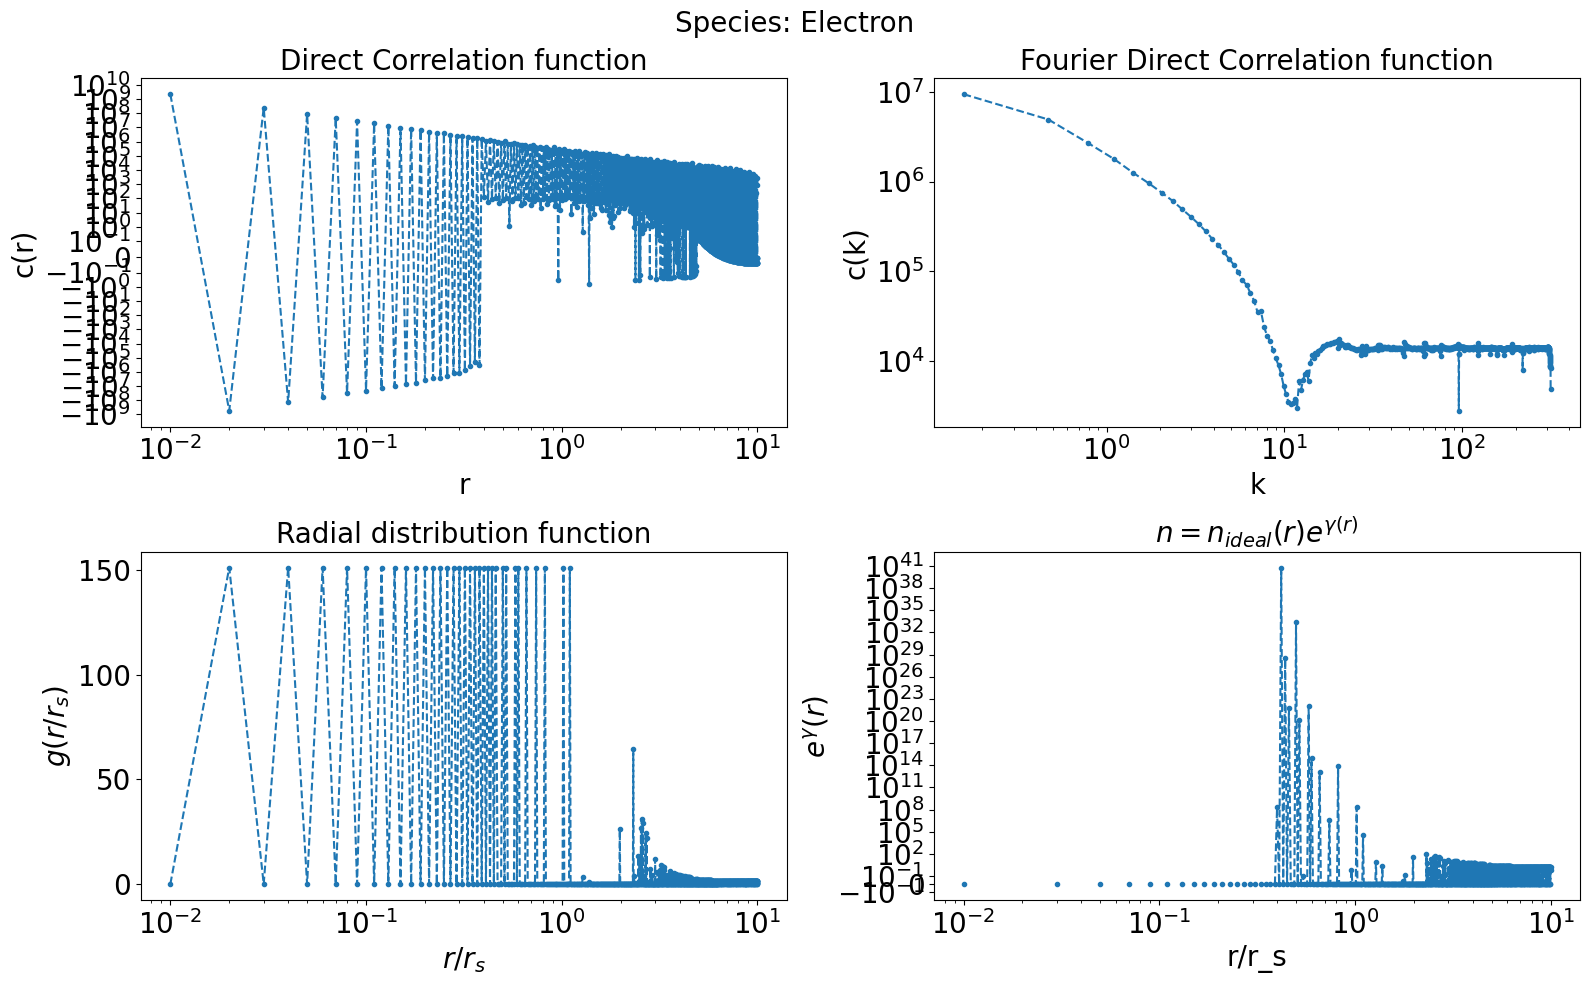

In [83]:
hnc2.HNC_solve(alpha=1, h_max=150)
hnc2.plot_g_all_species(data_to_compare=data_to_compare, data_names=data_names)
hnc2.plot_g_all_species(data_to_compare=data_to_compare, data_names=data_names, gmax=3)
hnc2.plot_species((1,1))

# Effective Potentials

In [27]:
# fig, ax = plt.subplots()

# ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
# ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
# ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
# ax.set_yscale('symlog',linthresh=1e-5)
# ax.set_xlim(1e-1,2)
# # ax.set_xscale('log')
# ax.legend()

In [25]:
# hnc2.invert_HNC( 1)

In [26]:
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0], label="Effective")
# ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
# ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-1e0,1e2)
# ax.set_yscale('symlog',linthresh=1)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)

# Check!

In [ ]:
# N_species = 1
# Gamma = np.array(  [[1]])
# names = ["Ion Effective"] 
# kappa = 1
# rho = np.array([3/(4*np.pi)])
# hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=1,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)
# hnc_check.βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
# hnc_check.split_βu_matrix()
# hnc_check.get_βu_k_matrices()

# hnc_check.HNC_solve(alpha=1)


In [ ]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [ ]:
# hnc_check.plot_g_all_species()

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
# ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
# ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-0.1,3)
# ax.set_xlim(0,5)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)